This cell imports all necessary libraries for data manipulation, visualization, and model training. It loads your feature dataset and shows basic information about its size and class distribution.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import joblib

# Load the dataset
features_path = "../Extracted Features/features_combined_extended.csv"
df = pd.read_csv(features_path)

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of real samples: {sum(df['label'])}")
print(f"Number of fake samples: {len(df) - sum(df['label'])}")
df.head()

Dataset shape: (50999, 35)
Number of real samples: 31403
Number of fake samples: 19596


,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,...,mfcc_std_13,zcr,rms,spec_centroid,spec_bandwidth,spec_rolloff,spec_contrast,pitch_mean,pitch_std,label
0,-273.23062,156.86295,-12.459389,39.521244,7.261509,20.760902,10.876893,6.671418,8.002936,-2.015242,...,8.468726,0.038824,0.080054,1996.462129,2520.143519,3979.527585,18.420540,1101.2179,975.68524,1
1,-256.68625,164.62277,-24.539558,46.576527,8.700367,24.575415,3.850657,2.503540,3.840417,-8.115285,...,9.748356,0.037877,0.085325,2006.927278,2555.434765,4123.725680,18.574471,1242.4299,1021.02410,1
2,-263.25812,126.02191,10.519299,13.731587,2.823969,-0.808076,-7.619192,-5.127765,-4.889288,1.153538,...,9.188738,0.062159,0.104295,1134.146538,1487.393990,2435.680651,20.445393,540.1105,399.05110,1
3,-268.97958,163.25003,-14.135536,47.959816,11.678417,21.017126,10.747832,0.312097,4.160600,-6.515533,...,7.966469,0.035575,0.079903,1853.842217,2415.677132,3658.823627,18.410713,1051.3286,991.42800,1
4,-248.03513,70.74574,1.210651,28.527310,10.741900,7.105612,-21.620281,-8.006638,-14.241697,0.926107,...,10.499650,0.132538,0.046797,1905.150103,1836.264358,3898.651541,20.023784,1371.6462,1039.58670,1


# Cell 2: Data Exploration and Visualization
This cell creates visualizations to better understand your data. It shows the class distribution, correlation between features, and distributions of key features separated by class. This helps identify potential patterns and differences between real and fake audio samples.

/var/folders/fw/y64qmm0n3g36fd5hs00npdyw0000gn/T/ipykernel_59142/3845146308.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#FF5555', '#5555FF'])


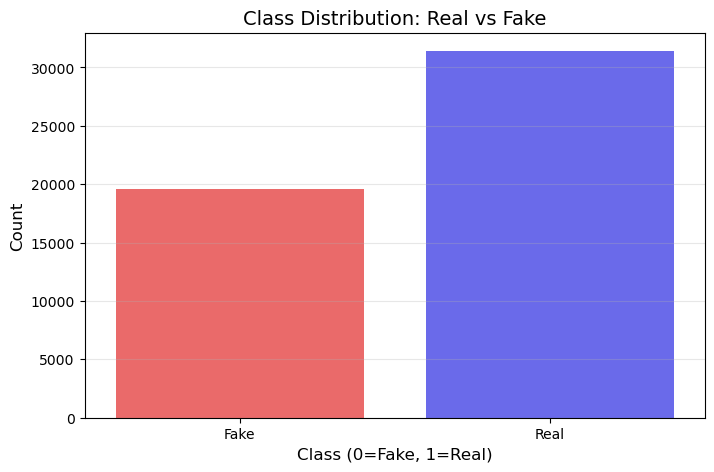

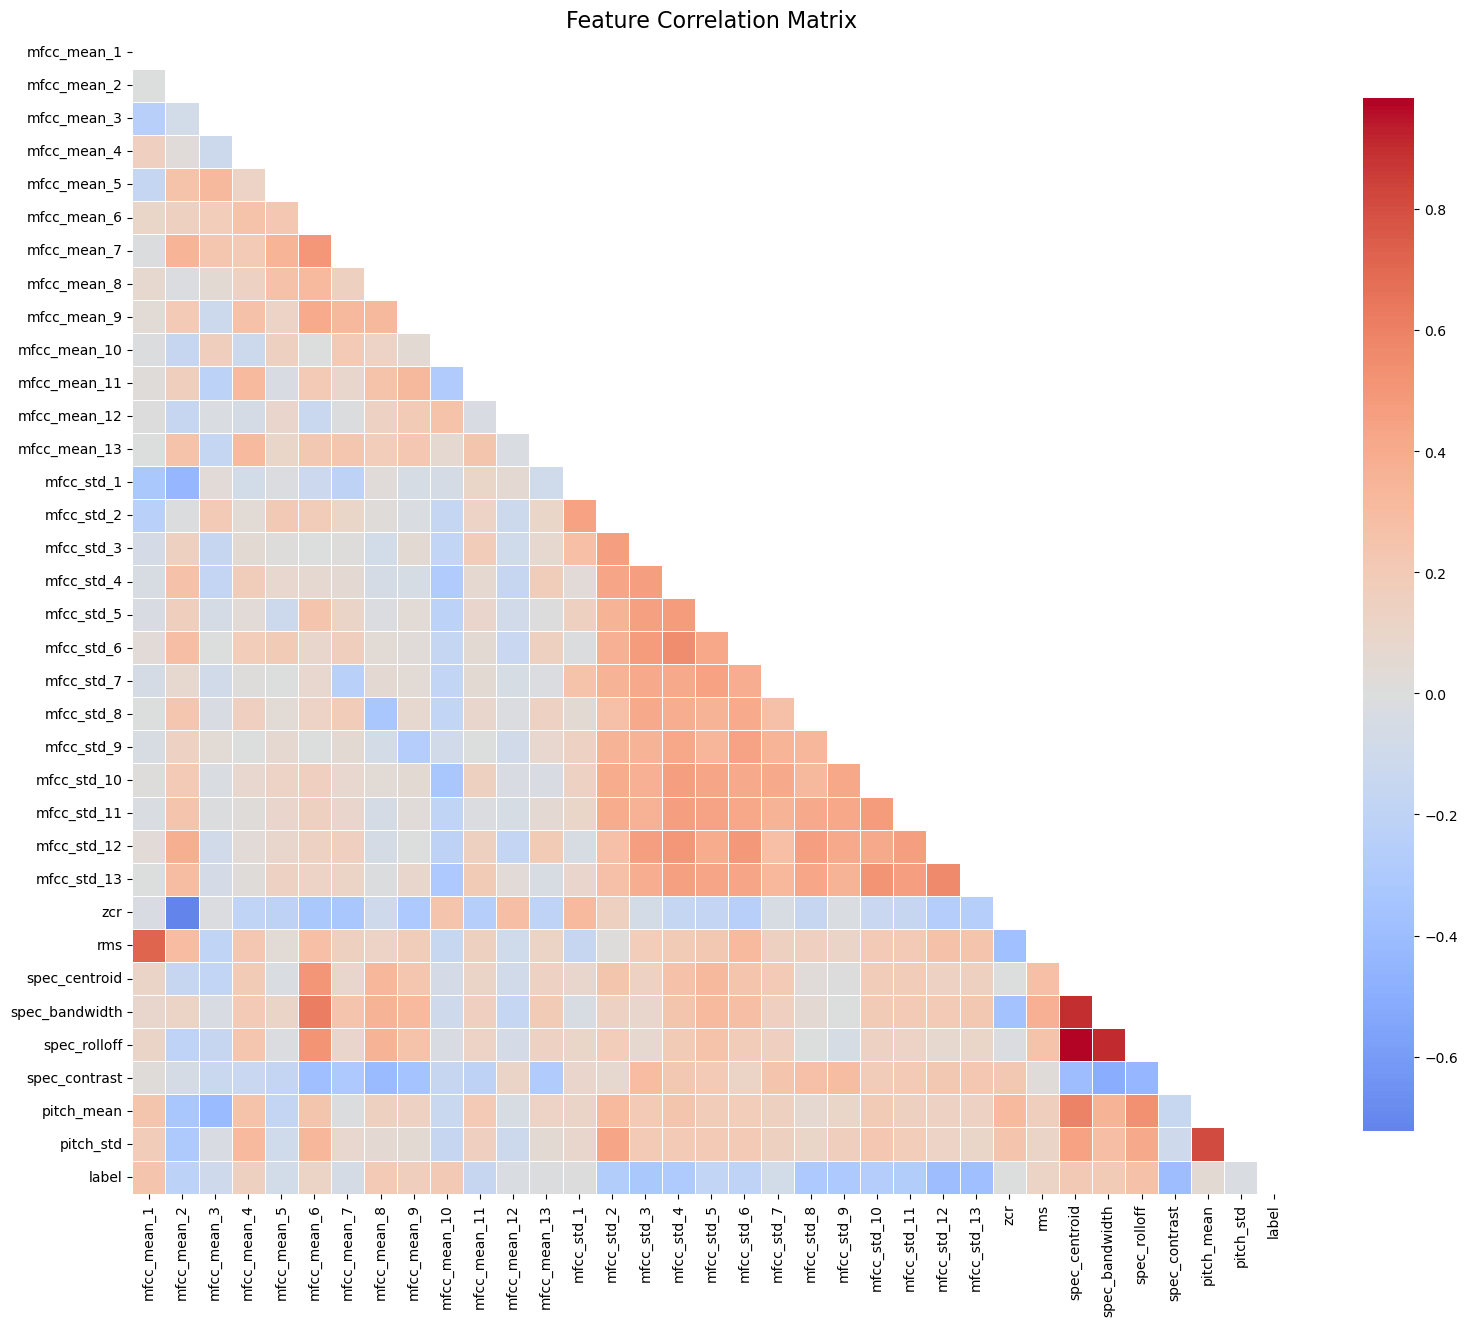

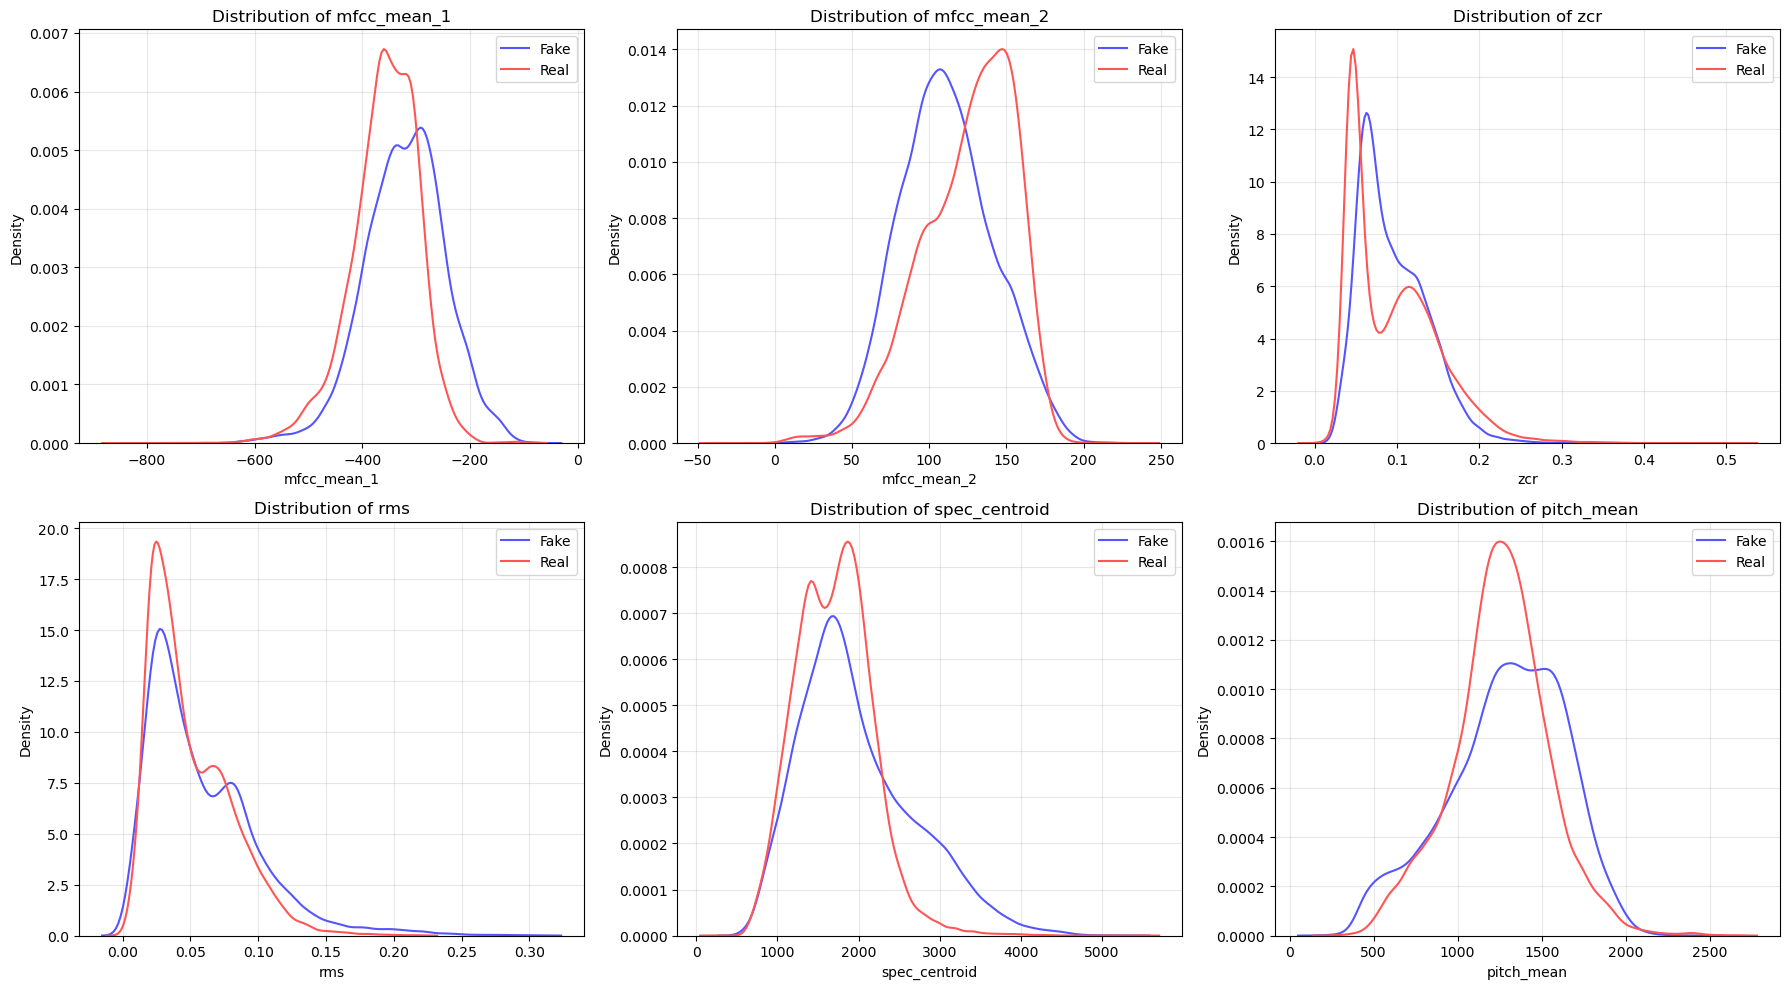

In [2]:
# Explore class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette=['#FF5555', '#5555FF'])
plt.title('Class Distribution: Real vs Fake', fontsize=14)
plt.xlabel('Class (0=Fake, 1=Real)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Fake', 'Real'])
plt.grid(axis='y', alpha=0.3)
plt.show()

# Explore feature correlations
plt.figure(figsize=(16, 14))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# Visualize feature distributions by class
features_to_plot = ['mfcc_mean_1', 'mfcc_mean_2', 'zcr', 'rms', 'spec_centroid', 'pitch_mean']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    sns.kdeplot(data=df, x=feature, hue='label', palette=['#FF5555', '#5555FF'], ax=ax, common_norm=False)
    ax.set_title(f'Distribution of {feature}', fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.grid(alpha=0.3)
    ax.legend(['Fake', 'Real'])

plt.tight_layout()
plt.show()

# Cell 3: Data Preparation and Train-Test Split
This cell prepares the data for training by splitting it into training and testing sets while preserving class proportions. It also standardizes the features to have zero mean and unit variance, which helps models converge faster and perform better.

In [3]:
# Separate features and target
X = df.drop("label", axis=1)
y = df["label"]

# Split the data with stratification to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame for better visualization (optional)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Check the shapes
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")
print(f"Training set class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Testing set class distribution: {pd.Series(y_test).value_counts().to_dict()}")

Training set shape: (40799, 34)
Testing set shape: (10200, 34)
Training set class distribution: {1: 25122, 0: 15677}
Testing set class distribution: {1: 6281, 0: 3919}


# Cell 4: Baseline XGBoost Model

/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:51:04] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Baseline XGBoost Performance:
Accuracy: 0.9871
Precision: 0.9861
Recall: 0.9930
F1 Score: 0.9895


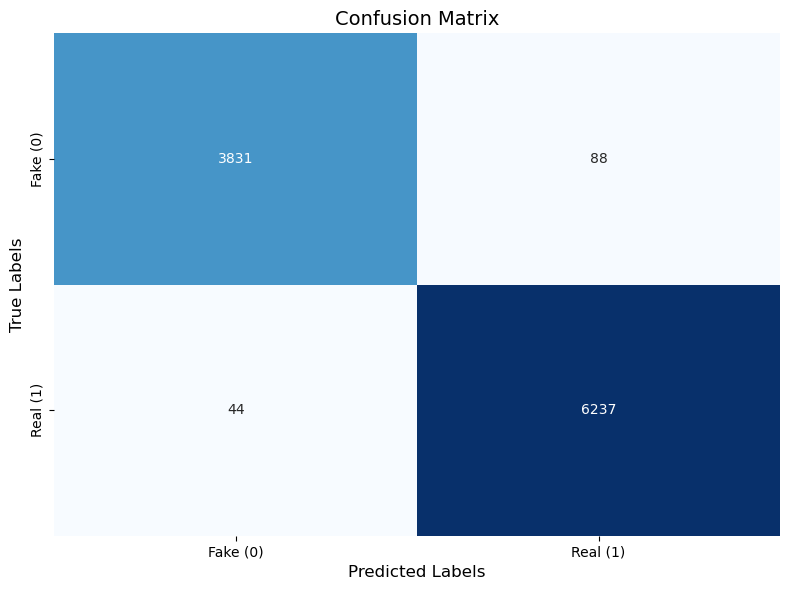


Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      3919
        Real       0.99      0.99      0.99      6281

    accuracy                           0.99     10200
   macro avg       0.99      0.99      0.99     10200
weighted avg       0.99      0.99      0.99     10200



In [4]:
# Create and train a baseline XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_scaled)
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (Real)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Baseline XGBoost Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks([0.5, 1.5], ['Fake (0)', 'Real (1)'])
plt.yticks([0.5, 1.5], ['Fake (0)', 'Real (1)'])
plt.tight_layout()
plt.show()

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Cell 5: Cross-Validation for Model Stability
This cell evaluates model stability using 5-fold cross-validation and examines feature importance to understand which features contribute most to predictions. The learning curve helps identify if the model is overfitting by comparing training and validation performance across different training set sizes.

/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:53:22] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:53:22] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:53:22] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/Arsh/lib/python3.10/site-p

Cross-Validation F1 Scores: [0.99027778 0.98923669 0.98806729 0.98981629 0.98961869]
Mean F1 Score: 0.9894
Standard Deviation: 0.0007


/var/folders/fw/y64qmm0n3g36fd5hs00npdyw0000gn/T/ipykernel_59142/100251582.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


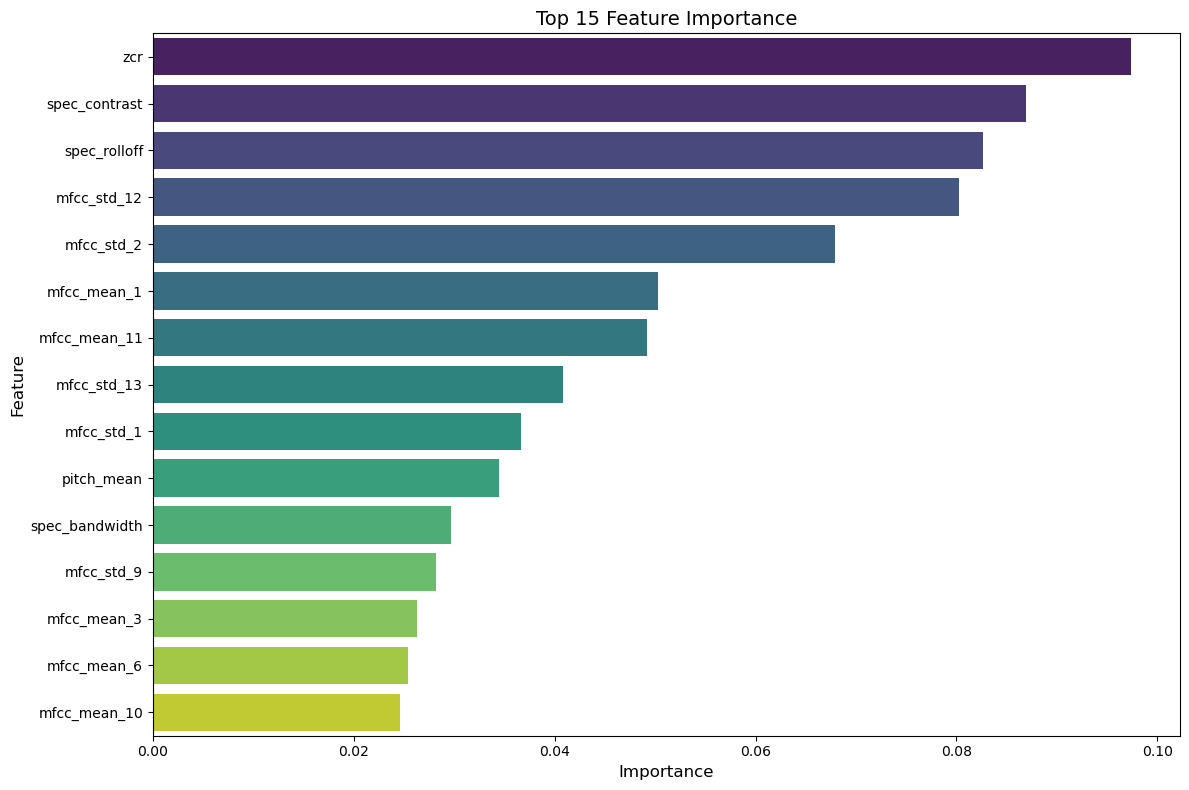

/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:53:23] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:53:23] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:53:23] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/Arsh/lib/python3.10/site-p

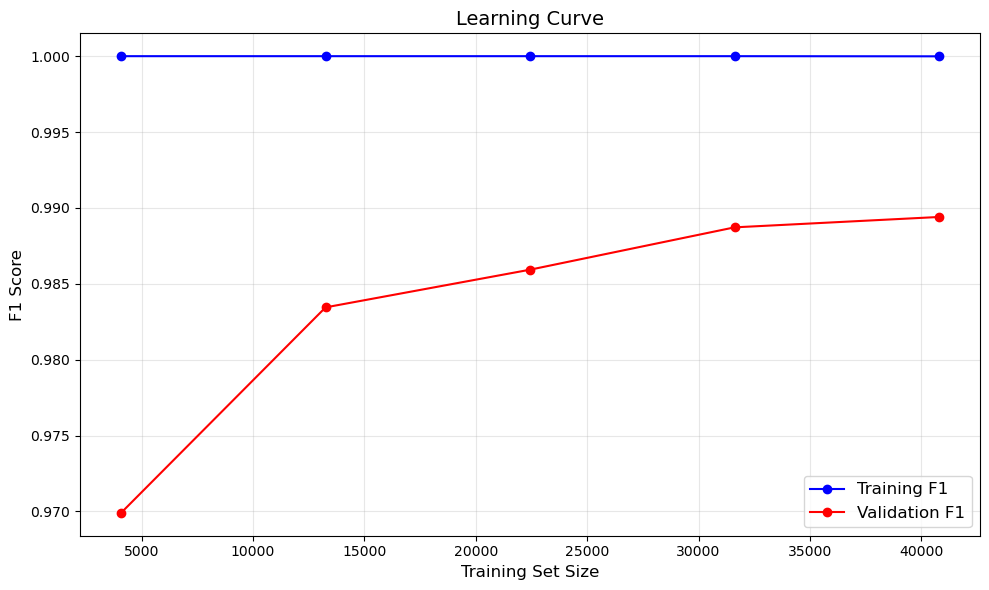

In [6]:
# Manual cross-validation implementation
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_scores = []

for train_index, val_index in kf.split(X_train_scaled):
    # Split the data
    X_cv_train, X_cv_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model
    cv_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    cv_model.fit(X_cv_train, y_cv_train)
    
    # Predict and evaluate
    y_cv_pred = cv_model.predict(X_cv_val)
    f1 = f1_score(y_cv_val, y_cv_pred)
    cv_scores.append(f1)

cv_scores = np.array(cv_scores)
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Feature importance analysis
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 15 features
top_features = feature_importance.head(15)
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 15 Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Manual learning curve implementation
train_sizes_abs = np.linspace(0.1, 1.0, 5)
train_sizes = []
train_scores = []
test_scores = []

for train_size in train_sizes_abs:
    # Calculate how many samples to use
    n_train_samples = int(len(X_train_scaled) * train_size)
    # Ensure we have at least some samples
    if n_train_samples < 100:
        n_train_samples = 100
    
    size_train_scores = []
    size_test_scores = []
    
    # Run cross-validation for this train size
    for train_idx, val_idx in kf.split(X_train_scaled[:n_train_samples]):
        # Split the data
        X_lc_train = X_train_scaled[:n_train_samples][train_idx]
        y_lc_train = y_train.iloc[:n_train_samples].iloc[train_idx]
        X_lc_val = X_train_scaled[:n_train_samples][val_idx]
        y_lc_val = y_train.iloc[:n_train_samples].iloc[val_idx]
        
        # Train the model
        lc_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
        lc_model.fit(X_lc_train, y_lc_train)
        
        # Calculate scores
        train_pred = lc_model.predict(X_lc_train)
        val_pred = lc_model.predict(X_lc_val)
        
        train_f1 = f1_score(y_lc_train, train_pred)
        val_f1 = f1_score(y_lc_val, val_pred)
        
        size_train_scores.append(train_f1)
        size_test_scores.append(val_f1)
    
    train_sizes.append(n_train_samples)
    train_scores.append(np.mean(size_train_scores))
    test_scores.append(np.mean(size_test_scores))

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, 'o-', color='blue', label='Training F1')
plt.plot(train_sizes, test_scores, 'o-', color='red', label='Validation F1')
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Learning Curve', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cell 6: Hyperparameter Tuning
This cell performs a manual grid search over key hyperparameters (max depth, learning rate, number of estimators) to find the best combination. It trains and evaluates models with each parameter combination and tracks the F1 score to identify the optimal settings. The results are visualized to show how different parameters affect performance.

Starting manual hyperparameter tuning...
Parameters: max_depth=3, lr=0.01, n_est=100, F1 Score: 0.9070


/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:32] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:32] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Parameters: max_depth=3, lr=0.01, n_est=200, F1 Score: 0.9224
Parameters: max_depth=3, lr=0.1, n_est=100, F1 Score: 0.9600


/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Parameters: max_depth=3, lr=0.1, n_est=200, F1 Score: 0.9709


/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Parameters: max_depth=5, lr=0.01, n_est=100, F1 Score: 0.9375


/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Parameters: max_depth=5, lr=0.01, n_est=200, F1 Score: 0.9506


/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:34] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Parameters: max_depth=5, lr=0.1, n_est=100, F1 Score: 0.9769


/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:34] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Parameters: max_depth=5, lr=0.1, n_est=200, F1 Score: 0.9854


/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:34] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Parameters: max_depth=7, lr=0.01, n_est=100, F1 Score: 0.9524


/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:35] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Parameters: max_depth=7, lr=0.01, n_est=200, F1 Score: 0.9662


/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:36] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Parameters: max_depth=7, lr=0.1, n_est=100, F1 Score: 0.9858


/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:36] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Parameters: max_depth=7, lr=0.1, n_est=200, F1 Score: 0.9908

Best parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 200}
Best F1 score: 0.9908


/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:56:37] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Optimized Model Performance:
Accuracy: 0.9886
Precision: 0.9867
Recall: 0.9949
F1 Score: 0.9908

Improvement over baseline:
Accuracy: 0.0016
F1 Score: 0.0000


/var/folders/fw/y64qmm0n3g36fd5hs00npdyw0000gn/T/ipykernel_59142/327517178.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Parameters', data=results_df, palette='viridis')


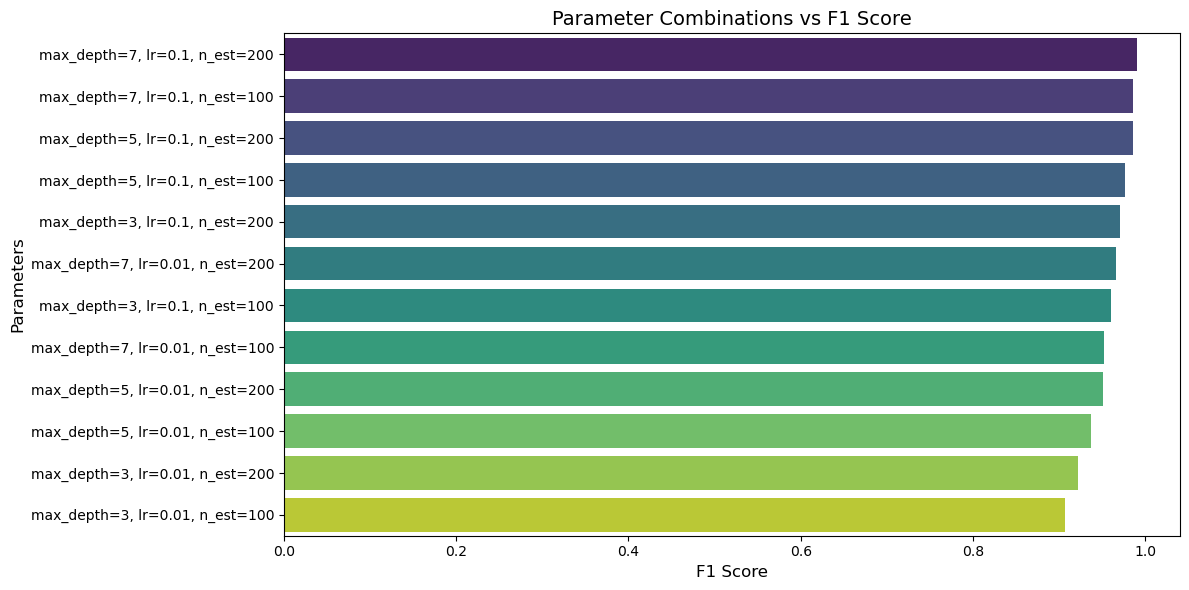

In [8]:
# Define a smaller set of hyperparameters to test
max_depth_values = [3, 5, 7]
learning_rate_values = [0.01, 0.1]
n_estimators_values = [100, 200]

# Dictionary to store results
results = {}

# Manual grid search
best_f1 = 0
best_params = {}

print("Starting manual hyperparameter tuning...")

for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        for n_estimators in n_estimators_values:
            # Create and configure model
            model = XGBClassifier(
                max_depth=max_depth,
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                use_label_encoder=False,
                eval_metric="logloss",
                random_state=42
            )
            
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Evaluate on test set
            y_pred = model.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred)
            
            # Store result
            param_combination = f"max_depth={max_depth}, lr={learning_rate}, n_est={n_estimators}"
            results[param_combination] = f1
            
            print(f"Parameters: {param_combination}, F1 Score: {f1:.4f}")
            
            # Check if this is the best so far
            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'n_estimators': n_estimators
                }

print(f"\nBest parameters: {best_params}")
print(f"Best F1 score: {best_f1:.4f}")

# Train model with best parameters
best_model = XGBClassifier(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

best_model.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred_best = best_model.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)
best_precision = precision_score(y_test, y_pred_best)
best_recall = recall_score(y_test, y_pred_best) 
best_f1 = f1_score(y_test, y_pred_best)

print("\nOptimized Model Performance:")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1 Score: {best_f1:.4f}")

# Compare with baseline
print("\nImprovement over baseline:")
print(f"Accuracy: {(best_accuracy - accuracy):.4f}")
print(f"F1 Score: {(best_f1 - f1):.4f}")

# Visualize results
plt.figure(figsize=(12, 6))
results_df = pd.DataFrame({
    'Parameters': list(results.keys()),
    'F1 Score': list(results.values())
}).sort_values('F1 Score', ascending=False)

sns.barplot(x='F1 Score', y='Parameters', data=results_df, palette='viridis')
plt.title('Parameter Combinations vs F1 Score', fontsize=14)
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Parameters', fontsize=12)
plt.tight_layout()
plt.show()

# Cell 7: Final Model Training and Saving
This cell trains the final model with the optimized hyperparameters and evaluates its performance on the test set. It also saves both the model and the scaler for later deployment in your application. The ROC curve is plotted to visualize the model's ability to discriminate between real and fake voice samples across different threshold settings.

/opt/anaconda3/envs/Arsh/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:58:02] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final Model Performance:
Accuracy: 0.9886
Precision: 0.9867
Recall: 0.9949
F1 Score: 0.9908

Model and scaler saved to the 'Models' directory


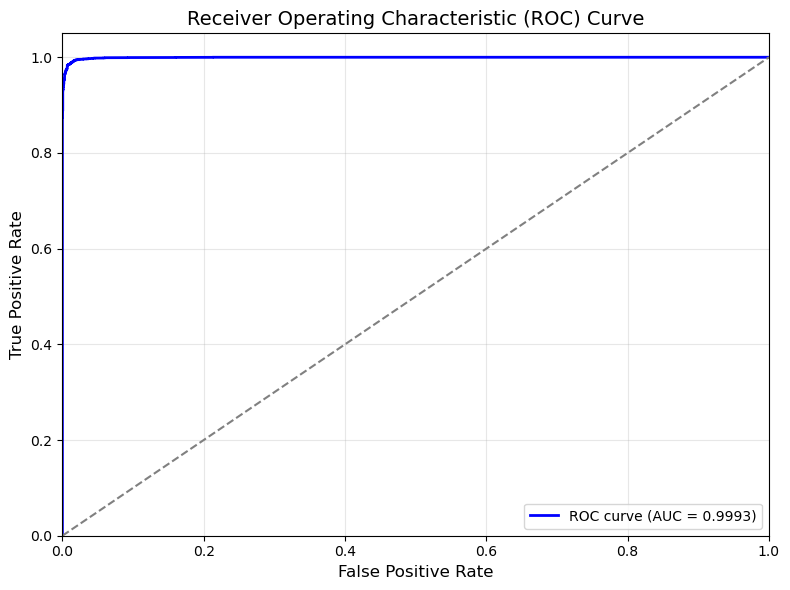

In [9]:
# Train final model with best parameters
final_model = XGBClassifier(
    max_depth=7,
    learning_rate=0.1,
    n_estimators=200,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# Train on the entire training set
final_model.fit(X_train_scaled, y_train)

# Final evaluation on test set
y_pred_final = final_model.predict(X_test_scaled)
y_prob_final = final_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)

print("Final Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")

# Save the model and scaler for deployment
import joblib

# Create a directory for the models if it doesn't exist
import os
if not os.path.exists('../Models'):
    os.makedirs('../Models')

# Save model and scaler
joblib.dump(final_model, '../Models/deepfake_voice_detector.pkl')
joblib.dump(scaler, '../Models/feature_scaler.pkl')

print("\nModel and scaler saved to the 'Models' directory")

# Plot ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob_final)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/fw/y64qmm0n3g36fd5hs00npdyw0000gn/T/ipykernel_59142/2982254792.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


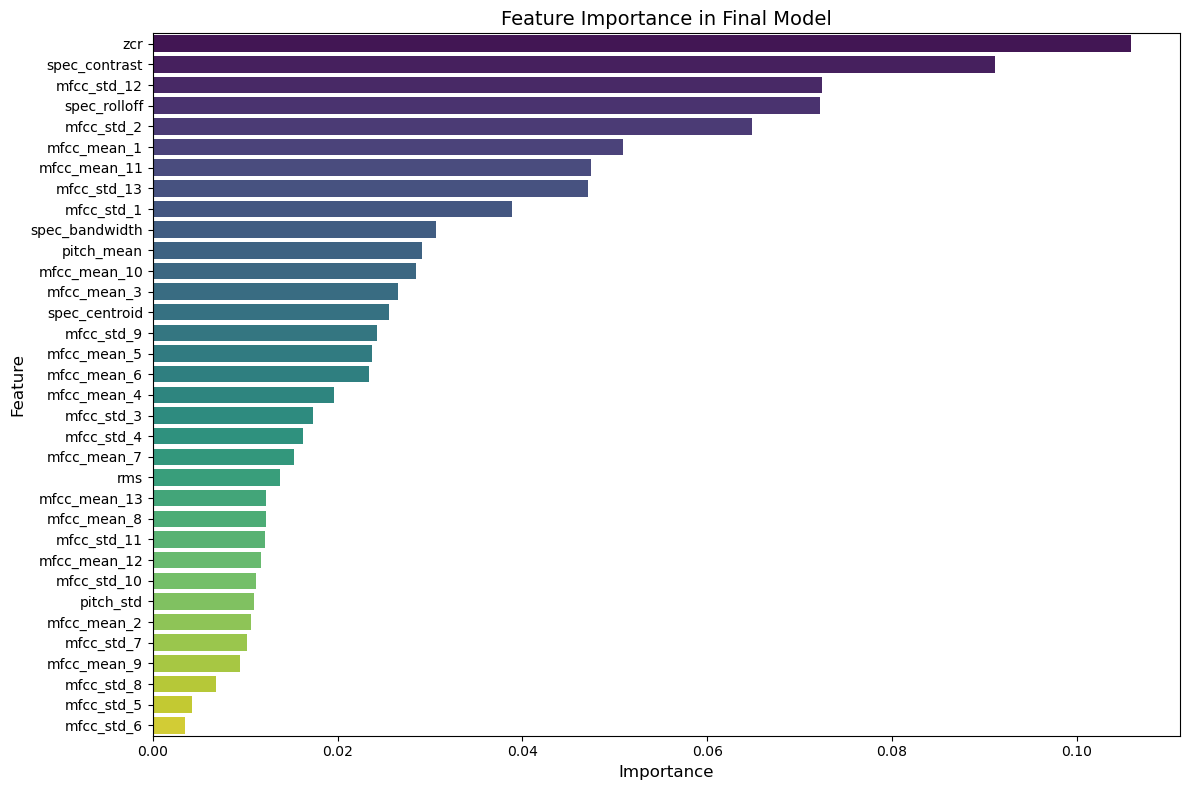

Real-time Prediction Simulation:
Prediction: Real
Confidence: 0.7982
Probability Real: 0.7982
Probability Fake: 0.2018
Actual Label: Real

Threshold Analysis:
 Threshold  Accuracy  Precision   Recall  F1 Score
      0.50  0.988627   0.986736 0.994905  0.990804
      0.60  0.989118   0.989372 0.992995  0.991180
      0.70  0.988039   0.991697 0.988855  0.990274
      0.80  0.987157   0.995010 0.984079  0.989514
      0.90  0.979706   0.997054 0.969909  0.983294
      0.95  0.970000   0.998332 0.952874  0.975073
      0.99  0.909510   1.000000 0.853049  0.920698


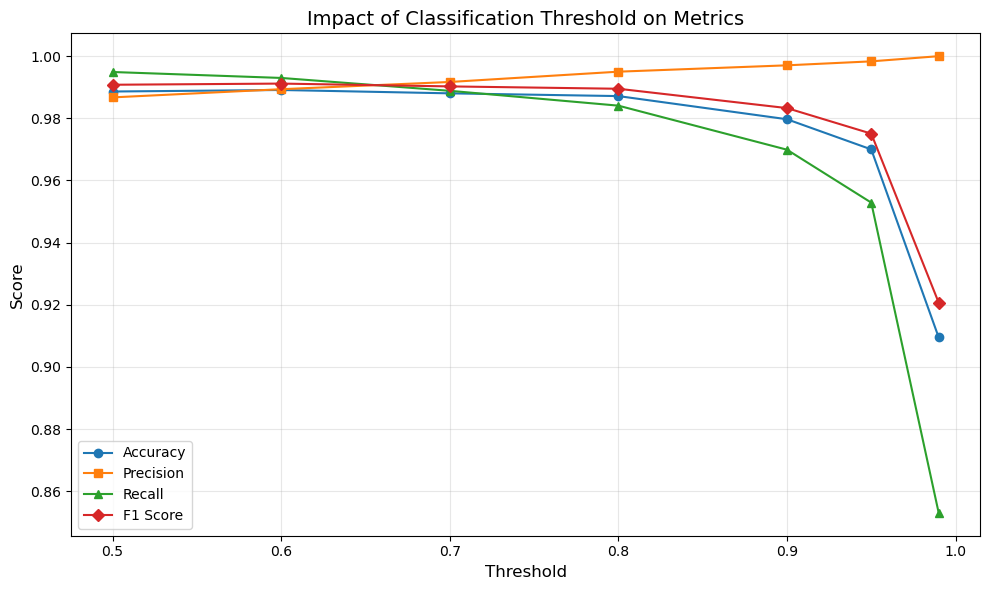

In [10]:
# Feature importance visualization with better formatting
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot all features
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance in Final Model', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Simulate real-time prediction function
def predict_audio_sample(features_dict, model, scaler):
    """
    Simulate prediction for a single audio sample
    
    Args:
        features_dict: Dictionary of extracted features
        model: Trained XGBoost model
        scaler: Fitted StandardScaler
    
    Returns:
        Prediction and confidence
    """
    # Convert features dictionary to array
    features = pd.DataFrame([features_dict])
    
    # Scale features
    scaled_features = scaler.transform(features)
    
    # Make prediction
    prediction = model.predict(scaled_features)[0]
    probability = model.predict_proba(scaled_features)[0]
    
    # Return results
    result = {
        'prediction': 'Real' if prediction == 1 else 'Fake',
        'confidence': probability[prediction],
        'probability_real': probability[1],
        'probability_fake': probability[0]
    }
    
    return result

# Create a sample prediction example
# Load the model and scaler (they're already in memory but for demonstration)
loaded_model = joblib.load('../Models/deepfake_voice_detector.pkl')
loaded_scaler = joblib.load('../Models/feature_scaler.pkl')

# Sample feature vector from test set
sample_idx = 42  # Choose any index
sample_features = {}
for i, col in enumerate(X.columns):
    sample_features[col] = X_test_scaled[sample_idx, i]

# Get prediction
prediction_result = predict_audio_sample(sample_features, loaded_model, loaded_scaler)

print("Real-time Prediction Simulation:")
print(f"Prediction: {prediction_result['prediction']}")
print(f"Confidence: {prediction_result['confidence']:.4f}")
print(f"Probability Real: {prediction_result['probability_real']:.4f}")
print(f"Probability Fake: {prediction_result['probability_fake']:.4f}")
print(f"Actual Label: {'Real' if y_test.iloc[sample_idx] == 1 else 'Fake'}")

# Threshold analysis
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
threshold_results = []

for threshold in thresholds:
    y_pred_threshold = (y_prob_final >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_threshold)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    
    threshold_results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Display threshold analysis
threshold_df = pd.DataFrame(threshold_results)
print("\nThreshold Analysis:")
print(threshold_df.to_string(index=False))

# Plot threshold impact
plt.figure(figsize=(10, 6))
plt.plot(threshold_df['Threshold'], threshold_df['Accuracy'], 'o-', label='Accuracy')
plt.plot(threshold_df['Threshold'], threshold_df['Precision'], 's-', label='Precision')
plt.plot(threshold_df['Threshold'], threshold_df['Recall'], '^-', label='Recall')
plt.plot(threshold_df['Threshold'], threshold_df['F1 Score'], 'D-', label='F1 Score')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Impact of Classification Threshold on Metrics', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()